# Medium Difficulty ML Model - UK Housing Price Prediction Model

Info taken from https://www.ons.gov.uk/peoplepopulationandcommunity/personalandhouseholdfinances/expenditure 

UK Housing Price Prediction Model
Generating realistic UK housing data...
Generated 3000 property records

Sample of the data:
            region property_type  bedrooms  bathrooms  square_feet  \
0  East of England      Detached         3          3          749   
1            Wales          Flat         2          2         1091   
2       North West      Terraced         5          2         1311   
3    East Midlands      Detached         3          2          707   
4       South East      Detached         2          2         1312   

   year_built  has_garden  has_garage  has_parking  distance_to_station_km  \
0        1972           0           1            0                3.971314   
1        1970           1           0            1                1.091891   
2        1945           0           1            1                2.636687   
3        1942           1           1            1                0.694973   
4        1852           1           0            1            

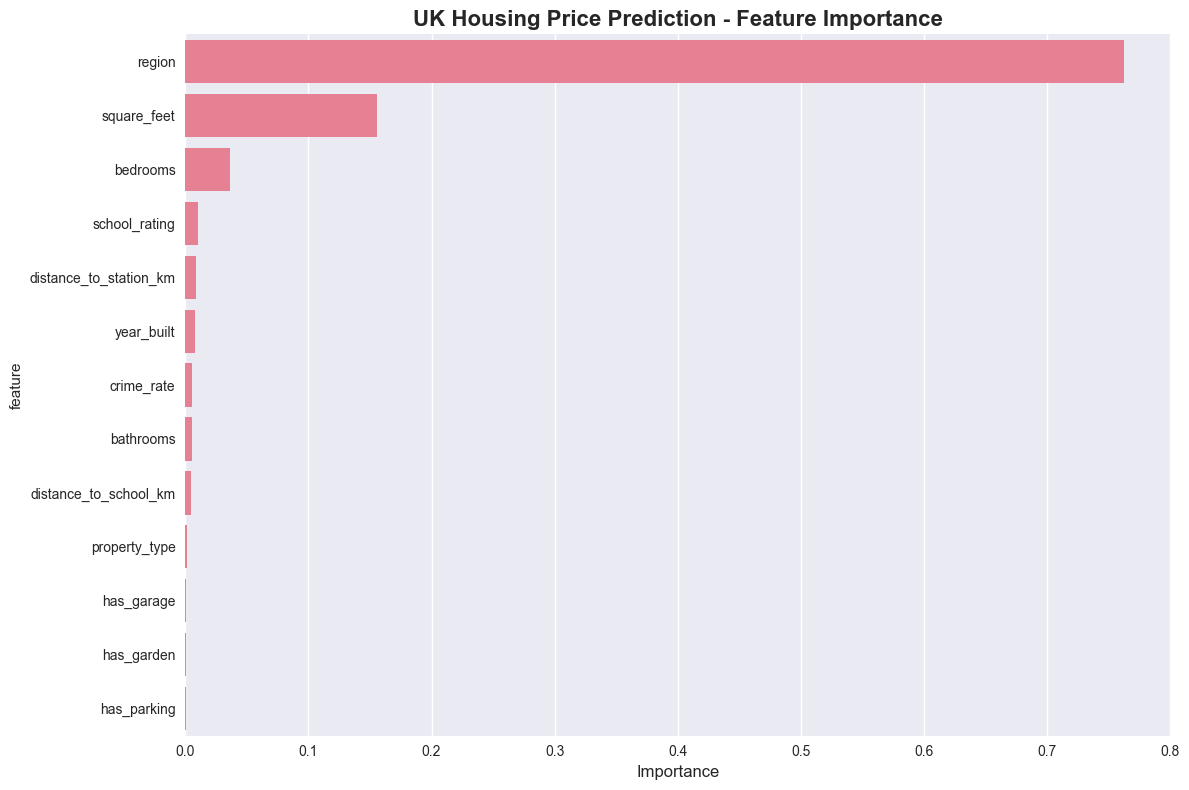


 Top 5 Most Important Features:
   1. region: 0.762
   5. square_feet: 0.156
   3. bedrooms: 0.036
   12. school_rating: 0.010
   10. distance_to_station_km: 0.008


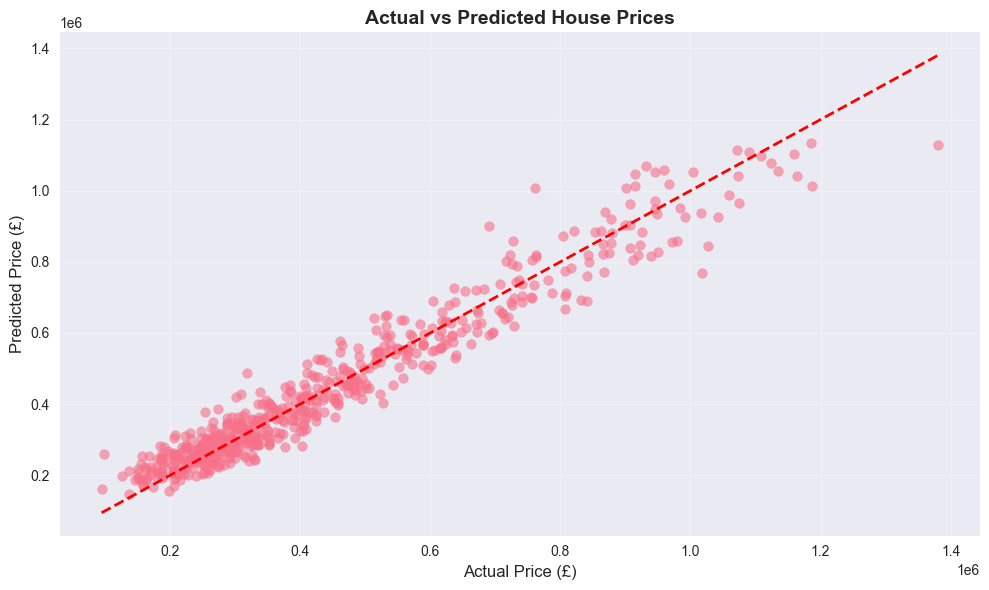

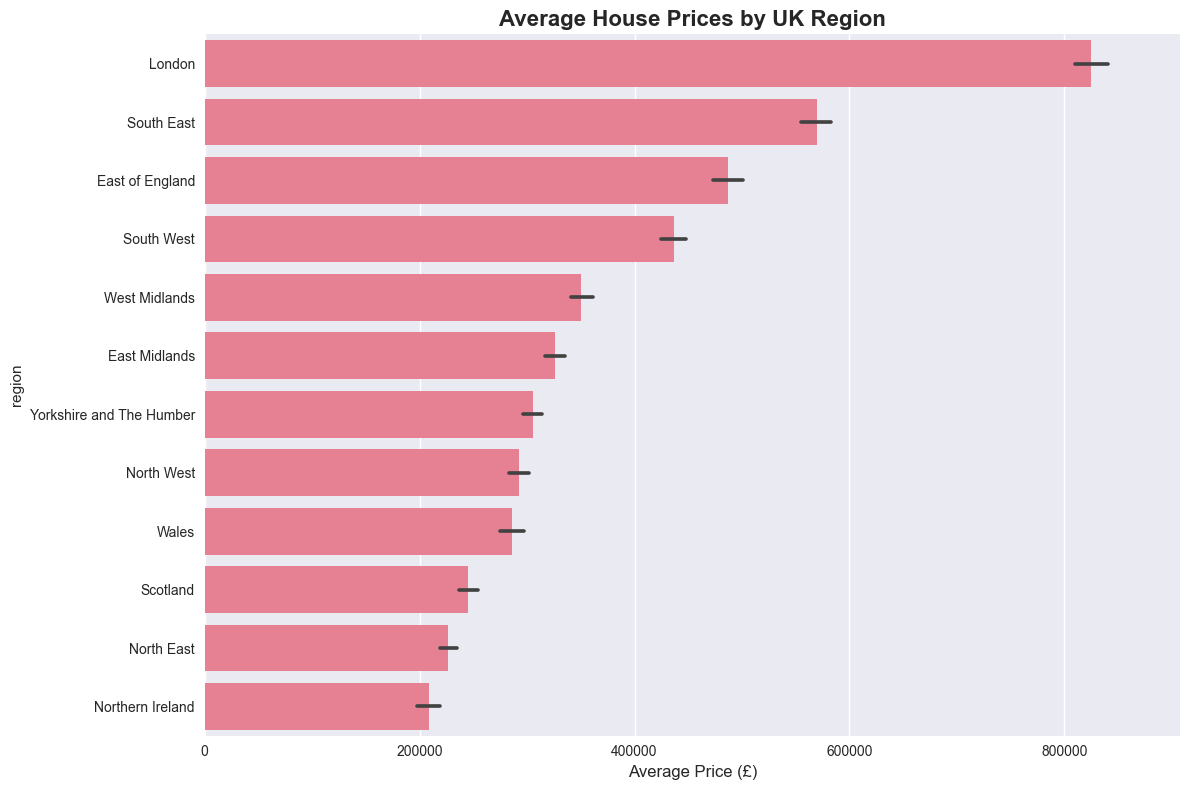


Example Predictions:

Example 1: 2-bed Flat in London
   Predicted Price: £658,061

Example 2: 3-bed Semi-Detached in North West
   Predicted Price: £282,240

Analysis complete! Check the generated PNG files for visualizations.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class UKHousingPredictor:
    def __init__(self):
        self.model = RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            n_jobs=-1  # Use all CPU cores
        )
        self.label_encoders = {}
        self.feature_names = None
        self.is_trained = False
        
    def generate_realistic_uk_data(self, n_samples=3000):
        """
        Generate realistic UK housing data with proper regional variations
        """
        np.random.seed(42)
        
        # UK regions with realistic price multipliers
        regions = ['London', 'South East', 'South West', 'East of England', 
                  'West Midlands', 'East Midlands', 'Yorkshire and The Humber',
                  'North West', 'North East', 'Scotland', 'Wales', 'Northern Ireland']
        
        # Realistic average prices by region (2023 estimates)
        region_avg_prices = {
            'London': 650000, 'South East': 450000, 'South West': 350000,
            'East of England': 380000, 'West Midlands': 280000, 'East Midlands': 260000,
            'Yorkshire and The Humber': 240000, 'North West': 230000, 'North East': 180000,
            'Scotland': 190000, 'Wales': 220000, 'Northern Ireland': 170000
        }
        
        data = {
            'region': np.random.choice(regions, n_samples, p=[0.15, 0.12, 0.1, 0.1, 0.09, 0.08, 0.08, 0.08, 0.06, 0.06, 0.05, 0.03]),
            'property_type': np.random.choice(['Terraced', 'Semi-Detached', 'Detached', 'Flat', 'Bungalow'], n_samples, p=[0.3, 0.25, 0.2, 0.2, 0.05]),
            'bedrooms': np.random.choice([1, 2, 3, 4, 5, 6], n_samples, p=[0.1, 0.25, 0.3, 0.2, 0.1, 0.05]),
            'bathrooms': np.random.choice([1, 2, 3, 4], n_samples, p=[0.4, 0.4, 0.15, 0.05]),
            'square_feet': np.random.normal(1000, 400, n_samples).astype(int),
            'year_built': np.random.randint(1850, 2023, n_samples),
            'has_garden': np.random.choice([0, 1], n_samples, p=[0.3, 0.7]),
            'has_garage': np.random.choice([0, 1], n_samples, p=[0.4, 0.6]),
            'has_parking': np.random.choice([0, 1], n_samples, p=[0.2, 0.8]),
            'distance_to_station_km': np.random.exponential(2, n_samples),
            'crime_rate': np.random.uniform(0.5, 8.0, n_samples),  # Crimes per 1000 people
            'school_rating': np.random.uniform(1, 5, n_samples),   # Ofsted-like rating
            'distance_to_school_km': np.random.exponential(1, n_samples),
        }
        
        df = pd.DataFrame(data)
        
        # Ensure square footage is realistic
        df['square_feet'] = np.clip(df['square_feet'], 400, 3000)
        
        # Calculate base price with realistic factors
        base_price = (
            df['bedrooms'] * 25000 +
            df['bathrooms'] * 20000 +
            df['square_feet'] * 150 +
            (2023 - df['year_built']) * 200 +  # Older houses can be more expensive
            df['has_garden'] * 15000 +
            df['has_garage'] * 10000 +
            df['has_parking'] * 8000 -
            df['distance_to_station_km'] * 5000 -
            df['crime_rate'] * 3000 +
            df['school_rating'] * 12000 -
            df['distance_to_school_km'] * 2000
        )
        
        # Apply regional multipliers
        region_multipliers = {region: region_avg_prices[region] / 250000 for region in regions}
        df['regional_multiplier'] = df['region'].map(region_multipliers)
        df['base_price'] = base_price * df['regional_multiplier']
        
        # Add noise and ensure minimum price
        df['price'] = df['base_price'] + np.random.normal(0, 30000, n_samples)
        df['price'] = np.maximum(df['price'], 50000)  # Minimum £50k
        
        # Remove temporary columns
        df = df.drop(['regional_multiplier', 'base_price'], axis=1)
        
        return df
    
    def preprocess_data(self, df):
        """Preprocess the data for training"""
        df = df.copy()
        
        # Encode categorical variables
        categorical_columns = ['region', 'property_type']
        for col in categorical_columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            self.label_encoders[col] = le
        
        # Define features and target
        self.feature_names = [col for col in df.columns if col != 'price']
        X = df[self.feature_names]
        y = df['price']
        
        return X, y
    
    def train_model(self, df):
        """Train the Random Forest model"""
        print("Training Random Forest model...")
        
        X, y = self.preprocess_data(df)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        # Train model
        self.model.fit(X_train, y_train)
        
        # Predictions
        y_pred = self.model.predict(X_test)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        print("Model training completed!")
        print(f"Model Performance:")
        print(f"   Mean Absolute Error: £{mae:,.0f}")
        print(f"   Root Mean Square Error: £{rmse:,.0f}")
        print(f"   R² Score: {r2:.3f}")
        
        # Cross-validation
        cv_scores = cross_val_score(self.model, X, y, cv=5, scoring='r2')
        print(f"   Cross-validation R²: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
        
        self.is_trained = True
        
        return X_test, y_test, y_pred
    
    def plot_feature_importance(self):
        """Plot feature importance"""
        if not self.is_trained:
            print("Model must be trained first!")
            return
        
        importances = self.model.feature_importances_
        feature_imp = pd.DataFrame({
            'feature': self.feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(12, 8))
        sns.barplot(data=feature_imp, x='importance', y='feature')
        plt.title('UK Housing Price Prediction - Feature Importance', fontsize=16, fontweight='bold')
        plt.xlabel('Importance', fontsize=12)
        plt.tight_layout()
        plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return feature_imp
    
    def plot_predictions_vs_actual(self, y_test, y_pred):
        """Plot predictions vs actual values"""
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.6)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('Actual Price (£)', fontsize=12)
        plt.ylabel('Predicted Price (£)', fontsize=12)
        plt.title('Actual vs Predicted House Prices', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('predictions_vs_actual.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def predict_custom_property(self, property_features):
        """Predict price for a custom property"""
        if not self.is_trained:
            print("Model must be trained first!")
            return None
        
        # Create DataFrame with the same structure as training data
        input_df = pd.DataFrame([property_features])
        
        # Encode categorical variables
        for col in ['region', 'property_type']:
            if col in input_df.columns and col in self.label_encoders:
                try:
                    input_df[col] = self.label_encoders[col].transform([input_df[col].iloc[0]])[0]
                except ValueError:
                    print(f"Unknown value for {col}. Using most common value.")
                    input_df[col] = 0
        
        # Ensure all features are present
        for feature in self.feature_names:
            if feature not in input_df.columns:
                input_df[feature] = 0  # Fill missing with 0
        
        # Reorder columns to match training
        input_df = input_df[self.feature_names]
        
        prediction = self.model.predict(input_df)[0]
        return prediction
    
    def analyze_regional_prices(self, df):
        """Analyze average prices by region"""
        if 'region' in df.columns and 'price' in df.columns:
            regional_prices = df.groupby('region')['price'].agg(['mean', 'std', 'count']).round(0)
            regional_prices = regional_prices.sort_values('mean', ascending=False)
            
            plt.figure(figsize=(12, 8))
            sns.barplot(data=df, x='price', y='region', order=regional_prices.index)
            plt.title('Average House Prices by UK Region', fontsize=16, fontweight='bold')
            plt.xlabel('Average Price (£)', fontsize=12)
            plt.xlim(0, regional_prices['mean'].max() * 1.1)
            plt.tight_layout()
            plt.savefig('regional_prices.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            return regional_prices

def main():
    """Main function to run the complete analysis"""
    print("UK Housing Price Prediction Model")
    print("=" * 50)
    
    # Initialise predictor
    predictor = UKHousingPredictor()
    
    # Generate sample data
    print("Generating realistic UK housing data...")
    housing_data = predictor.generate_realistic_uk_data(3000)
    
    print(f"Generated {len(housing_data)} property records")
    print("\nSample of the data:")
    print(housing_data.head())
    
    print(f"\nData Overview:")
    print(f"   Average Price: £{housing_data['price'].mean():,.0f}")
    print(f"   Price Range: £{housing_data['price'].min():,.0f} - £{housing_data['price'].max():,.0f}")
    print(f"   Number of Regions: {housing_data['region'].nunique()}")
    
    # Train model
    X_test, y_test, y_pred = predictor.train_model(housing_data)
    
    # Visualisations
    print("\nGenerating visualizations...")
    
    # Feature importance
    importance_df = predictor.plot_feature_importance()
    print("\n Top 5 Most Important Features:")
    for i, row in importance_df.head().iterrows():
        print(f"   {i+1}. {row['feature']}: {row['importance']:.3f}")
    
    # Predictions vs Actual
    predictor.plot_predictions_vs_actual(y_test, y_pred)
    
    # Regional analysis
    regional_stats = predictor.analyze_regional_prices(housing_data)
    
    # Example predictions
    print("\nExample Predictions:")
    example_properties = [
        {
            'region': 'London',
            'property_type': 'Flat',
            'bedrooms': 2,
            'bathrooms': 1,
            'square_feet': 800,
            'year_built': 2010,
            'has_garden': 0,
            'has_garage': 0,
            'has_parking': 1,
            'distance_to_station_km': 0.5,
            'crime_rate': 3.0,
            'school_rating': 4.0,
            'distance_to_school_km': 0.8
        },
        {
            'region': 'North West',
            'property_type': 'Semi-Detached',
            'bedrooms': 3,
            'bathrooms': 2,
            'square_feet': 1200,
            'year_built': 1985,
            'has_garden': 1,
            'has_garage': 1,
            'has_parking': 1,
            'distance_to_station_km': 1.2,
            'crime_rate': 2.0,
            'school_rating': 3.5,
            'distance_to_school_km': 0.5
        }
    ]
    
    for i, prop in enumerate(example_properties, 1):
        predicted_price = predictor.predict_custom_property(prop)
        if predicted_price:
            print(f"\nExample {i}: {prop['bedrooms']}-bed {prop['property_type']} in {prop['region']}")
            print(f"   Predicted Price: £{predicted_price:,.0f}")
    
    print("\n" + "=" * 50)

if __name__ == "__main__":
    main() 